In [1]:
from transformers import ViTFeatureExtractor, ViTForImageClassification, TrainingArguments, Trainer
from datasets import Dataset
import torch
from collections import defaultdict
from tqdm import tqdm
import pandas as pd
import evaluate
from transformers import AutoFeatureExtractor
from transformers import AutoImageProcessor
from transformers import DefaultDataCollator
from transformers import AutoModelForImageClassification
from datasets import load_dataset, Image
from torchvision.transforms import RandomResizedCrop, Compose, Normalize, ToTensor, Resize
import os
from datasets import load_metric
import numpy as np
import matplotlib.pyplot as plt
import huggingface_hub

In [2]:
vit_model = "google/vit-base-patch16-224-in21k"

In [3]:
huggingface_hub.login(os.getenv("HF_TOKEN"))

Token will not been saved to git credential helper. Pass `add_to_git_credential=True` if you want to set the git credential as well.
Token is valid (permission: write).
Your token has been saved to C:\Users\deser\.cache\huggingface\token
Login successful


In [4]:
image_processor = AutoImageProcessor.from_pretrained(vit_model)
model = ViTForImageClassification.from_pretrained(vit_model)
data_collator = DefaultDataCollator()
accuracy = evaluate.load("accuracy")

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [5]:
accuracy_metric = load_metric("accuracy")
f1_metric = load_metric("f1")
# precision_metric = load_metric("precision")
recall_metric = load_metric("recall")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)

    # Berechnung der Metriken
    accuracy = accuracy_metric.compute(predictions=predictions, references=labels)
    f1 = f1_metric.compute(predictions=predictions, references=labels, average='weighted')
    # precision = precision_metric.compute(predictions=predictions, references=labels, average='weighted')
    recall = recall_metric.compute(predictions=predictions, references=labels, average='weighted')
    
    # Rückgabe der Metriken als Dictionary
    return {
        'accuracy': accuracy['accuracy'],
        'f1': f1['f1'],
        # 'precision': precision['precision'],
        'recall': recall['recall'],
    }

C:\Users\deser\AppData\Local\Temp\ipykernel_16564\721318933.py:1: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  accuracy_metric = load_metric("accuracy")


In [6]:
normalize = Normalize(mean=image_processor.image_mean, std=image_processor.image_std)
size = (
    image_processor.size["shortest_edge"]
    if "shortest_edge" in image_processor.size
    else (image_processor.size["height"], image_processor.size["width"])
)
_transforms = Compose([Resize(size), ToTensor(), normalize])

In [7]:
print(size)

(224, 224)


In [8]:
def transforms(examples):
    examples["pixel_values"] = [_transforms(img.convert("RGB")) for img in examples["image"]]
    del examples["image"]
    return examples

In [9]:
dataset = load_dataset("desertraider/mahjong_souls_tiles", keep_in_memory=True)
NUM_CLASSES = len(set(dataset['train']['label']))
print(NUM_CLASSES)

Resolving data files:   0%|          | 0/1080 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/897 [00:00<?, ?it/s]

34


In [10]:
dataset = dataset.with_transform(transforms)

In [11]:
labels = dataset["train"].features["label"].names
label2id, id2label = dict(), dict()
for i, label in enumerate(labels):
    label2id[label] = str(i)
    id2label[str(i)] = label

In [12]:
dataset["train"][0]

{'label': 0,
 'pixel_values': tensor([[[-0.9216, -0.9216, -0.9137,  ..., -0.9137, -0.9137, -0.9137],
          [-0.8510, -0.8353, -0.7882,  ..., -0.8431, -0.8745, -0.8824],
          [-0.7333, -0.7098, -0.6000,  ..., -0.7490, -0.8275, -0.8431],
          ...,
          [-0.7804, -0.7725, -0.7412,  ..., -0.7882, -0.8118, -0.8118],
          [-0.7882, -0.7882, -0.7882,  ..., -0.7882, -0.7882, -0.7804],
          [-0.7882, -0.7961, -0.8196,  ..., -0.7804, -0.7647, -0.7569]],
 
         [[-0.7725, -0.7725, -0.7725,  ..., -0.7725, -0.7725, -0.7725],
          [-0.7333, -0.7333, -0.7020,  ..., -0.7333, -0.7569, -0.7569],
          [-0.6784, -0.6706, -0.6078,  ..., -0.6863, -0.7255, -0.7333],
          ...,
          [-0.6784, -0.6706, -0.6549,  ..., -0.6784, -0.6941, -0.6941],
          [-0.6784, -0.6784, -0.6784,  ..., -0.6706, -0.6706, -0.6627],
          [-0.6706, -0.6784, -0.6941,  ..., -0.6627, -0.6471, -0.6392]],
 
         [[-0.5137, -0.5137, -0.5137,  ..., -0.5137, -0.5059, -0.5059],

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


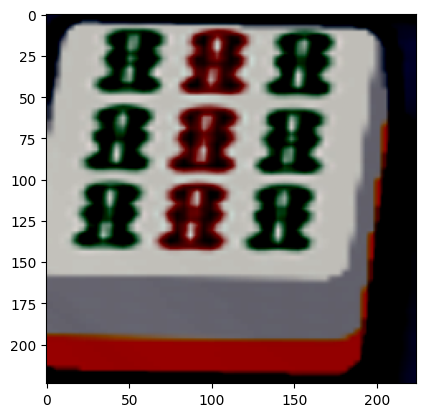

In [13]:
img = dataset["train"][850]["pixel_values"]
plt.imshow(img.permute(1, 2, 0))

In [14]:
# Feature Extractor und Modell laden

In [15]:
# Anzahl der Klassen anpassen
model = AutoModelForImageClassification.from_pretrained(
    vit_model,
    num_labels=len(labels),
    id2label=id2label,
    label2id=label2id,
)


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [16]:
# Trainingsargumente setzen
training_args = TrainingArguments(
    output_dir="vision_model_output", # Log-Dateien werden hier gespeichert
    logging_dir="vision_model_output/tb_logs", # Spezifischer Ort für TensorBoard-Logs
    remove_unused_columns=False,
    evaluation_strategy="epoch",
    save_strategy="epoch", # Speichert nur am Ende jeder Epoche
    save_total_limit=2,
    learning_rate=5e-5,
    per_device_train_batch_size=16,
    gradient_accumulation_steps=4,
    per_device_eval_batch_size=16,
    num_train_epochs=250,
    warmup_ratio=0.1,
    logging_steps=1,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    hub_model_id="desertraider/mahjong_soul_vision",
    push_to_hub=True,
    auto_find_batch_size=True,
    # Setzen Sie Ihren Hugging Face Benutzernamen oder den Organisationsnamen, falls zutreffend
)

In [17]:
trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=data_collator,
    train_dataset=dataset["train"],
    eval_dataset=dataset["test"],
    tokenizer=image_processor,
    compute_metrics=compute_metrics,
    
)

N:\Projekte\pythonProject\mahjong-soul-detector\venv\Lib\site-packages\pydantic\_internal\_fields.py:128: UserWarning: Field "model_server_url" has conflict with protected namespace "model_".

You may be able to resolve this warning by setting `model_config['protected_namespaces'] = ()`.
  warnings.warn(
N:\Projekte\pythonProject\mahjong-soul-detector\venv\Lib\site-packages\pydantic\_internal\_config.py:317: UserWarning: Valid config keys have changed in V2:
* 'schema_extra' has been renamed to 'json_schema_extra'
  warnings.warn(message, UserWarning)


In [18]:
trainer.train()

TrainOutput(global_step=4250, training_loss=0.2148646897008533, metrics={'train_runtime': 5505.3667, 'train_samples_per_second': 49.043, 'train_steps_per_second': 0.772, 'total_flos': 2.092883798863872e+19, 'train_loss': 0.2148646897008533, 'epoch': 250.0})

In [19]:

# Modell speichern und auf Hugging Face hochladen
trainer.save_model()
trainer.push_to_hub()


'https://huggingface.co/desertraider/mahjong_soul_vision/tree/main/'